In [1]:
import pandas as pd
import numpy as np
from datetime import *
import networkx as nx
from collections import *
from tqdm.notebook import tqdm
import swifter
import dask
from multiprocessing.dummy import Pool
import multiprocessing
import matplotlib.pyplot as plt
import networkx.drawing
import pickle

In [2]:
def dateparse(time_as_a_unix_timestamp):
    return pd.to_datetime(time_as_a_unix_timestamp, unit="s").strftime("%Y-%m-%d")

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
def read_object(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

In [3]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 1. Data


```python
#Answers to questions
a2q = pd.read_csv("data/sx-stackoverflow-a2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to answers
c2a = pd.read_csv("data/sx-stackoverflow-c2a.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)

#Comments to questions
c2q = pd.read_csv("data/sx-stackoverflow-c2q.txt", sep=" " ,header=None, names=["user_a", "user_b", "time"], parse_dates=["time"], date_parser=dateparse)


```

```python
a2q.to_csv("data/a2q.csv", index=False)
c2q.to_csv("data/c2q.csv", index=False)
c2a.to_csv("data/c2a.csv", index=False)
```

In [4]:
a2q = pd.read_csv("data/a2q.csv", parse_dates=["time"], infer_datetime_format=True)
c2q = pd.read_csv("data/c2q.csv", parse_dates=["time"], infer_datetime_format=True)
c2a = pd.read_csv("data/c2a.csv", parse_dates=["time"], infer_datetime_format=True)

display("a2q", "c2q", "c2a")

,user_a,user_b,time
0,9,8,2008-08-01
1,1,1,2008-08-01
2,13,1,2008-08-01
3,17,1,2008-08-01
4,48,2,2008-08-01
...,...,...,...
17823520,2773607,1048138,2016-03-06
17823521,6018278,1982354,2016-03-06
17823522,3187183,1404306,2016-03-06
17823523,6022341,1667278,2016-03-06


In the merged graph we have weighted link and we have decided to build these weights in the following way:
-  we have assigned a score of 1.0 to "Answers to questions"
-  we have assigned a score of 0.7 to "Comments to questions"
-  we have assigned a score of 0.4 to "Comments to answers"

The reasons are that we have thought that the answers to questions are the more relevant in the merged graph because they are possible solutions of user's question. Then a bit less important are comments to questions, but they could be relevant to clarify the question or specify something. Comments to answer are the least relevant, but we have not wanted to penalize them too much because in some situations they could be useful.

In [5]:
#Answers to questions
a2q["weights"] = 1

#Comments to answers
c2a["weights"] = 0.4

#Comments to questions
c2q["weights"] = 0.7

Nice and simultaneous visualization of the three file!

In [6]:
display("a2q", "c2a", "c2q")

,user_a,user_b,time,weights
0,9,8,2008-08-01,1
1,1,1,2008-08-01,1
2,13,1,2008-08-01,1
3,17,1,2008-08-01,1
4,48,2,2008-08-01,1
...,...,...,...,...
17823520,2773607,1048138,2016-03-06,1
17823521,6018278,1982354,2016-03-06,1
17823522,3187183,1404306,2016-03-06,1
17823523,6022341,1667278,2016-03-06,1


In [7]:
totDataframe = pd.concat([a2q, c2a, c2q])
totDataframe

,user_a,user_b,time,weights
0,9,8,2008-08-01,1.0
1,1,1,2008-08-01,1.0
2,13,1,2008-08-01,1.0
3,17,1,2008-08-01,1.0
4,48,2,2008-08-01,1.0
...,...,...,...,...
20268146,1177890,4917254,2016-03-06,0.7
20268147,3345375,4022289,2016-03-06,0.7
20268148,3507137,1801524,2016-03-06,0.7
20268149,5617035,4368648,2016-03-06,0.7


In [8]:
totDataframe_2y = totDataframe[totDataframe.time.between("2015","2017")]
a2q_2y = a2q[a2q.time.between("2015","2017")]
c2q_2y = c2q[c2q.time.between("2015","2017")]
c2a_2y = c2a[c2a.time.between("2015","2017")]
display("a2q_2y", "c2a_2y", "c2q_2y", "totDataframe_2y")

,user_a,user_b,time,weights
14055617,335858,1045881,2015-01-01,1
14055618,3829874,3829874,2015-01-01,1
14055619,315228,3849055,2015-01-01,1
14055620,2182521,2182521,2015-01-01,1
14055621,3047078,4059893,2015-01-01,1
...,...,...,...,...
17823520,2773607,1048138,2016-03-06,1
17823521,6018278,1982354,2016-03-06,1
17823522,3187183,1404306,2016-03-06,1
17823523,6022341,1667278,2016-03-06,1


In [9]:
class EDGE:
    
    def __init__(self, from_n, to_n, time, w):
        self.from_n = from_n
        self.to_n = to_n
        self.w = w
        self.time = time
        
    def __repr__(self):
        return f"{self.from_n} -> {self.to_n} ::::: weight = {self.w} ::::: time: {self.time}"
    

In [10]:
class GRAPH:
    
    def __init__(self, nodes = [], edges = []):
        self.nodes = defaultdict(list, {k:[] for k in nodes})
        
        if(len(edges)>0):
            for edge in tqdm(edges):
                self.nodes[edge.from_n].append(edge)
                self.nodes[edge.to_n].append(edge)
        
        self.num_nodes = len(nodes)
        self.num_edges = len(edges)
        self.visited = []
        
    def add_node(self, node):
        self.nodes[node] = self.nodes.get(node, [])
        
    def add_edge(self, from_n, to_n, time, w):
        e = EDGE(from_n, to_n, time, w)
        
        self.nodes[from_n].append(e)
        self.nodes[to_n].append(e)
        
    def add_edge_object(self, edge):
        
        self.nodes[edge.from_n].append(edge)
        self.nodes[edge.to_n].append(edge)
        
    def add_edge_object_list(self, edges):
        
        for edge in edges:
            self.nodes[edge.from_n].append(edge)
            self.nodes[edge.to_n].append(edge)
            
    def get_edge(self, from_n, to_n):
        out_edge = None
        for edge in self.nodes[from_n]:
            if(edge.from_n == from_n and edge.to_n == to_n):
                out_edge = edge
        return out_edge
    
    def delete_edge(self, from_n, to_n):
        for edge in self.nodes[from_n]:
            if(edge.from_n == from_n and edge.to_n == to_n):
                self.nodes[from_n].remove(edge)
                
        for edge in self.nodes[to_n]:
            if(edge.from_n == from_n and edge.to_n == to_n):
                self.nodes[to_n].remove(edge)
                
    def delete_all_edge_of_node(self, node):
        for edge in self.nodes[node]:
    
            if(edge.to_n != node):
                self.nodes[edge.to_n].remove(edge)
                
             
            else:
                self.nodes[edge.from_n].remove(edge)
        
        self.nodes[node] = []
             
                
            
            
    def is_linked_from(self, node_a, node_b):
        return node_a in [n.from_n for n in self.nodes[node_b]]
    
    def is_linked_to(self, node_a, node_b):
        return node_a in [n.to_n for n in self.nodes[node_b]]
    
    def is_visited(self, node):
        return node in self.visited
            
    def clear_graph_path(self):
        self.visited = []
        
    def print_graph(self, size = (7,7)):
        G = nx.DiGraph()
        for k in tqdm(self.nodes):
            G.add_weighted_edges_from([(el.from_n, el.to_n, el.w) for el in self.nodes[k]])
            
        plt.figure(figsize=size)
        pos = nx.random_layout(G)
        nx.draw(G, pos, with_labels=True, font_weight='bold')

        labels = nx.get_edge_attributes(G, name="weight")
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);
        plt.savefig("data/test.pdf")
        plt.show()
        
    
    def __repr__(self):
        return f"{self.nodes}"
    
    def __len__(self):
        return len(self.nodes)

In [11]:
def make_graph(data):
    #nodes_graph_a2q_2y = pd.concat([a2q_2y["user_a"], a2q_2y["user_b"]], axis = 0).drop_duplicates().array
    g = GRAPH()
    with Pool(multiprocessing.cpu_count()) as pool:

        with tqdm(total = len(data)) as pbar:
            for el in pool.imap_unordered(lambda row: EDGE(row[1]["user_a"],row[1]["user_b"],row[1]["time"],row[1]["weights"]), data.iterrows()):
                g.add_edge_object(el)
                pbar.update()
                
    #save_object(g_a2q, "data/g_a2q.pkl")
    return g

## Functionality 2 - Find the best users!

In [12]:
totDataframe_2y[totDataframe_2y.time.between("2015-01-01","2015-01-01")].iloc[:1000]

,user_a,user_b,time,weights
14055617,335858,1045881,2015-01-01,1.0
14055618,3829874,3829874,2015-01-01,1.0
14055619,315228,3849055,2015-01-01,1.0
14055620,2182521,2182521,2015-01-01,1.0
14055621,3047078,4059893,2015-01-01,1.0
...,...,...,...,...
14056613,2415524,4403535,2015-01-01,1.0
14056614,264601,759452,2015-01-01,1.0
14056615,3732240,708807,2015-01-01,1.0
14056616,4372639,1915046,2015-01-01,1.0


In [13]:
test_g = make_graph(totDataframe_2y[totDataframe_2y.time.between("2015-01-01","2015-01-01")].iloc[:1000])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
#g_a2q = read_object("data/g_a2q.pkl")

In [105]:
def dijkstra(n, g, print_g = False, size=(7,7)):
    g.clear_graph_path()
    new_G = GRAPH()
    
    dist = defaultdict(float, {k:float('inf') for k in g.nodes})
    dist[n] = 0 
    new_G.add_node(n)
    
    
    for _ in tqdm(range(len(g))):  

        current_node = min([(dist[el], el) for el in g.nodes if not g.is_visited(el)], key=lambda e: e[0])[1]
        g.visited.append(current_node)
        
        if(dist[current_node] == float("inf")):
            break
        
        for neighbour in [el.to_n for el in g.nodes[current_node] if el.from_n == current_node]:

            alt = dist[current_node] + g.get_edge(current_node, neighbour).w
            
            if(alt < dist[neighbour]):
                dist[neighbour] = alt
                
                try:
                    new_G.delete_all_edge_of_node(neighbour)
                except:
                    pass
                
                new_G.add_edge(current_node, neighbour, g.get_edge(current_node,neighbour).time, alt)
                
    g.clear_graph_path()
    
    if(print_g):
        new_G.print_graph(size=size)
        
    return new_G, dist

In [16]:
def closenessCentrality(n, g, option = 1):
    
    if(option==1):
        new_G, dist = dijkstra(n, g)

        dist.pop(n)

        return sum((len(new_G)-1)/np.array([el for el in dist.values()]))
    
    elif(option==2):
        new_G, dist = dijkstra(n, g)

        dist.pop(n)

        dist = {key:val for key, val in dist.items() if val != float("inf")}

        return (len(dist))/sum(np.array([el for el in dist.values()]))
    
    else:
        print("This option does not exist!")
        return None

In [17]:
def degreeCentrality(n, g):
    
    in_degree = 0
    out_degree = 0
    
    for edge in g.nodes[n]:
        if(edge.from_n == n):
            out_degree += 1
        if(edge.to_n == n):
            in_degree += 1
            
    return out_degree, in_degree
        

In [18]:
#TODO
def betweeness(n, G):
    
    for s in G.nodes:
        new_G = dijkstra(s, G)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

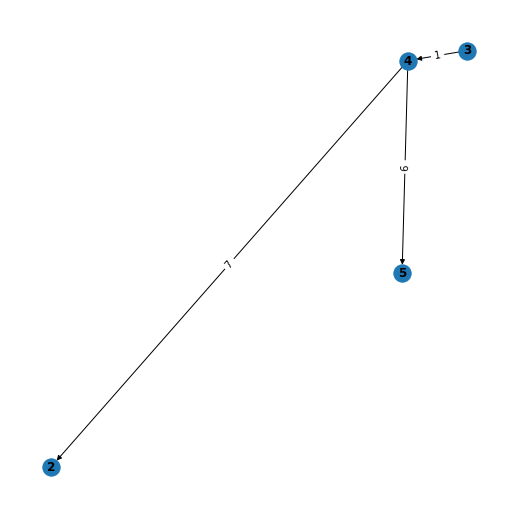

In [135]:
ng, dist = dijkstra(3,t2, print_g=True);

In [146]:


p = [1,3,5]
final_path = []
for i in range(0, len(p)-1):
    new_g, dist = dijkstra(p[i], t2)

    if(new_g.is_linked_from(p[i], p[i+1])):
        final_path.append(new_g.get_edge(p[i], p[i+1]))
    else:
        temp = []
        try:
            prec = [el for el in new_g.nodes[p[i+1]] if el.from_n != p[i+1]][0]
        except IndexError:
            print("Not possible")
            break

        temp.append(prec)

        while(not prec.from_n == p[i]):



            punt = [el for el in new_g.nodes[prec.from_n] if el.from_n != prec.from_n][0]

            temp.append(punt)

            prec = punt

        temp.reverse()
        final_path.extend(temp)
final_path    

sum([edge.w for edge in final_path])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

9

In [ ]:
closenessCentrality(2, t, option=2)

In [27]:
degreeCentrality(1, t)

In [31]:
ng

defaultdict(<class 'list'>, {1: [1 -> 3 ::::: weight = 12 ::::: time: 438], 2: [3 -> 2 ::::: weight = 14 ::::: time: 438, 2 -> 4 ::::: weight = 38 ::::: time: 438, 2 -> 6 ::::: weight = 59 ::::: time: 438], 3: [1 -> 3 ::::: weight = 12 ::::: time: 438, 3 -> 2 ::::: weight = 14 ::::: time: 438, 3 -> 5 ::::: weight = 18 ::::: time: 438], 5: [3 -> 5 ::::: weight = 18 ::::: time: 438], 4: [2 -> 4 ::::: weight = 38 ::::: time: 438], 6: [2 -> 6 ::::: weight = 59 ::::: time: 438]})

In [33]:
dist

defaultdict(float, {1: 0, 2: 14, 3: 12, 4: 38, 6: 59, 5: 18})

# GRAFI PER TEST

  0%|          | 0/6 [00:00<?, ?it/s]

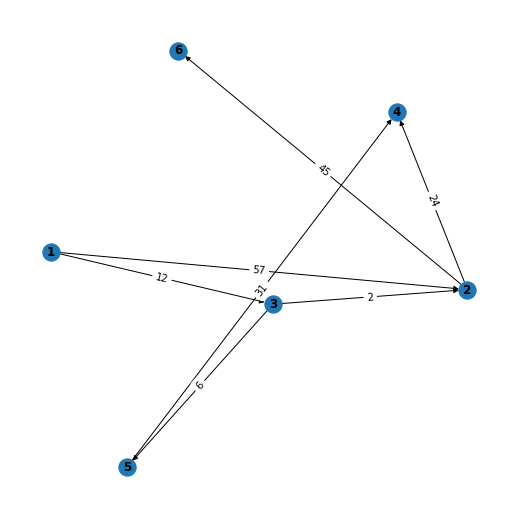

In [22]:
t = GRAPH()
t.add_edge(from_n=1,to_n=2, time="438", w=57)
t.add_edge(from_n=1,to_n=3, time="438", w=12)
t.add_edge(from_n=3,to_n=2, time="438", w=2)
t.add_edge(from_n=2,to_n=4, time="438", w=24)
t.add_edge(from_n=2,to_n=6, time="438", w=45)
t.add_edge(from_n=3,to_n=5, time="438", w=6)
t.add_edge(from_n=5,to_n=4, time="438", w=31)
t.print_graph()

  0%|          | 0/5 [00:00<?, ?it/s]

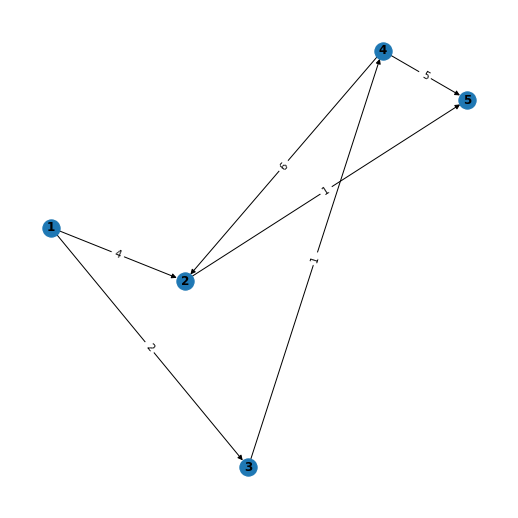

In [132]:
t2 = GRAPH()
t2.add_edge(from_n=1,to_n=3, time="438", w=2)
t2.add_edge(from_n=1,to_n=2, time="438", w=4)
t2.add_edge(from_n=3,to_n=4, time="438", w=1)
t2.add_edge(from_n=4,to_n=2, time="438", w=6)
t2.add_edge(from_n=2,to_n=5, time="438", w=1)
t2.add_edge(from_n=4,to_n=5, time="438", w=5)
t2.print_graph()